In [1]:
from IPython import get_ipython
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import gc
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, minmax_scale
from bayes_opt import BayesianOptimization
from sklearn.metrics import cohen_kappa_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#カテゴリカルの指定とか他の特徴の追加（特にclip）


In [2]:
#関数
def accumulated_features(df):
    df.loc[df['event_data'].str.contains('true'), 'true'] = 1
    df.loc[df['event_data'].str.contains('false'), 'false'] = 1
    current_t = 0
    current_f = 0
    for t, f in zip(df['true'], df['false']):
        if current_t < t:
            current_t = t
        t = current_t
        if current_f < f:
            current_f = f
        f = current_f
    return df

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# def convert(sub):
#     dic={0:0, 1:3, 2:2}
#     sub.loc[sub['accuracy']==0, 'accuracy_group'] = 0 #(n+1)*0
#     sub.loc[sub['accuracy']==1, 'accuracy_group'] = 3 #(0+1)*1
#     sub.loc[sub['accuracy']==0.5, 'accuracy_group'] = 2 #(1+1)*1
#     sub['accuracy_group'].fillna(1)
#     return sub['accuracy_group']

def type_check(all_df):
    print('type_check')
    print('installation_id')
    for x in all_df['installation_id'].unique():
        if not type(x) == str:
            print(str(type(x)))
    print('game_session')
    for x in all_df['game_session'].unique():
        if not type(x) == str:
            print(str(type(x)))
    print('title')
    for x in all_df['title'].unique():
        if not type(x) == str:
            print(str(type(x)))
    return


def groupon(df, group_col, calc_col, method):
    dic=df.groupby(group_col)[calc_col].agg([method])[method].to_dict()
    return df[group_col].map(dic)

def game_session_feature(all_df):
    #時系列に整列していないとバグる
    print('game_session_feature:')
    all_df['exp_assess'] = 0
    all_df['final_game_time'] = 0
    df = all_df[all_df['type']=='Assessment']#Assessmentのみに絞る
    df = df[df['event_code']==2000]#gamestartに絞る
    df['installation_id|title'] = df['installation_id'].str.cat(df['title'], sep='|')
    unique_ea1 = df['installation_id|title'].unique()#index順のarray
    for u in tqdm(unique_ea1):
        #installation_idとtitleの組み合わせでイテレーション
        df_it = df[df['installation_id|title']==u]
        #game_sessionから、それが現在のイテレーションの中で何番目に固有か(何度目か)
        itg_unique_func = lambda g: int(np.where(df_it['game_session'].unique() == g)[0])#tupleからintへ
        #installation_idとtitleの組み合わせで固有のgame_sessionを抽出し、mapでそれが何番目のgame_sessionかを返す
        df.loc[df['installation_id|title']==u, 'exp_assess'] = df_it['game_session'].map(itg_unique_func)
    all_df.loc[(all_df['type']=='Assessment') & (all_df['event_code']==2000), 'exp_assess'] = df['exp_assess'].values
    del df, df_it
    gc.collect()
    
    return all_df

def transform(all_df):
    #installation_idに対するtitleのnuniqueと
    #その予測対象までのinstallation_idに対するcollect:falseの数
    #その予測対象までのinstallation_idに対するcollect:trueの数
    #その予測対象までのinstallation_idに対する上記二つからのaccuracy_group
    all_df = all_df[all_df['type'].isin(['Assessment', 'Game'])]
    
    title_dic = {'Mushroom Sorter (Assessment)':'Mushroom Sorter', 'Bird Measurer (Assessment)':'Bird Measurer', 'Cauldron Filler (Assessment)':'Cauldron Filler', 'Cart Balancer (Assessment)':'Cart Balancer', 'Chest Sorter (Assessment)':'Chest Sorter'}
    all_df.loc[all_df['type']=='Assessment', 'title'] = all_df.loc[all_df['type']=='Assessment', 'title'].map(title_dic)
    #Assessmentに対して前のGameのかかった時間を出す(Gameは0)
    #event_countを使わないと進んでないのに高速で間違いまくるやつのスピードが早くなる
    all_df['timestamp']=pd.to_datetime(all_df['timestamp'])
    all_df['date'] = pd.to_datetime(all_df.timestamp)
    all_df['hour'] = all_df['date'].dt.hour#何時か
    all_df['weekday'] = all_df['date'].dt.weekday

    #↓ラベルをくっつける用+特徴量生成用
    all_df['game_session|installation_id'] = all_df['game_session'].str.cat(all_df['installation_id'], sep='|')
    #そのgame_sessionの合計トランザクション数->startから未来の数がわかってしまうためNG
    session_count_dic = all_df.loc[all_df['type']=='Game', 'game_session|installation_id'].value_counts().to_dict()
    all_df['session_count'] = all_df['game_session|installation_id'].map(session_count_dic)
    count_mean = all_df.loc[~(all_df['session_count']==0), 'session_count'].mean()#0でないものの平均
    all_df.loc[all_df['session_count']==0, 'session_count'] = count_mean 
    all_df['session_count'] = all_df['session_count'].fillna(count_mean)
    all_df = game_session_feature(all_df)

    del session_count_dic
    gc.collect()
    
    #それぞれのgame_sessionの最終的にかかった時間（type=GameなのでStart=2000まで）
    all_df.loc[all_df['type']=='Assessment', 'game_time'] = 0#高速化用、最終的にgame_time自体は落とすため問題ない
    all_df['final_game_time'] = groupon(all_df, 'game_session', 'game_time', 'max')
    fgt_mean = all_df.loc[~(all_df['final_game_time']==0), 'final_game_time'].mean()
    all_df['final_game_time'] = all_df['final_game_time'].fillna(fgt_mean)
    all_df.loc[all_df['final_game_time'] == 0, 'final_game_time'] = fgt_mean
    #そのsessionの経過スピード（type=GameなのでStart=2000まで）
    all_df['session_speed'] = all_df['final_game_time'] / all_df['session_count']
    #全てのユーザがそれぞれのゲームにかかる時間の平均
    all_df['(A)title->session_speed.mean'] = groupon(all_df, 'title', 'session_speed', 'mean')
    #特徴量生成用
    all_df['title|installation_id'] = all_df['title'].str.cat(all_df['installation_id'], sep='|')
    #installation_idごとのユニークなタイトルの数
    all_df['installation_id|title.nunique'] = all_df.groupby(['installation_id'])['title'].transform('nunique')
    #それぞれのinstallation_idのスピードの平均
    all_df['(B)title|installation_id->session_speed.mean'] = groupon(all_df, 'title|installation_id', 'session_speed', 'mean')
    #平均と比べてそのゲームを進めるのが早いか
    all_df['(A)-(B)'] = all_df['(A)title->session_speed.mean'] - all_df['(B)title|installation_id->session_speed.mean']
    #平均何時にプレイしているか(installation_idに対してhourが1つだとvarは0)
    all_df['installation_id->hour.mean'] = groupon(all_df, 'installation_id', 'hour', 'mean').astype(int)
    all_df['installation_id->hour.var'] = groupon(all_df, 'installation_id', 'hour', 'var')
    #game_session一回につき平均何時間プレイしているか(installation_idに対してgame_sessionが1つだとvarは0)
    all_df['installation_id->final_game_time.mean'] = groupon(all_df, 'installation_id', 'final_game_time', 'mean').astype(int)
    all_df['installation_id->final_game_time.var'] = groupon(all_df, 'installation_id', 'final_game_time', 'var')
    #それぞれのinstallation_idのトランザクションに対して連番を振る
    all_df['installation_id|transaction_count'] = all_df.groupby(['installation_id']).grouper.group_info[0]
    all_df = all_df.drop(['session_speed', 'session_count', 'final_game_time'], axis=1)

    print('accumulated_feature:')
    all_df['true'] = 0
    all_df['false'] = 0
    assess_df=all_df[all_df['type']=='Assessment']
    for iteration_id, df_it in tqdm(assess_df.groupby('installation_id', sort = False)):
        df_it = accumulated_features(df_it)
        assess_df.loc[(assess_df['installation_id']==iteration_id), 'true'] = df_it['true'].values
        assess_df.loc[(assess_df['installation_id']==iteration_id), 'false'] = df_it['false'].values
    all_df.loc[all_df['type']=='Assessment', 'true']=assess_df['true'].values
    all_df.loc[all_df['type']=='Assessment', 'false']=assess_df['false'].values
    del assess_df
    gc.collect()
    all_df['accum_accuracy'] = all_df['true'] / (all_df['false']+1)
    display(all_df['accum_accuracy'].value_counts())
    ##############最後のgame_sessionに関する特徴量
    #今回は最終的な予測対象の1行がtrueかどうかを予測するモデルにする
    
    return all_df

def data_squeeze(input_df, mode):
    print('data_squeeze:')
    input_df['squeeze_target'] = 0
    input_df['temp_index']=input_df.index.values
    df = input_df[input_df['type']=='Assessment']#アセスメントだけに処理を絞る
    df = df[df['event_code']==2000]#gamestartに絞る
    
    del input_df
    gc.collect()

    if mode=='test':
        print('test_squeeze:')
        df['installation_id|game_session'] = 0#使わないがあとでdropするため
        id_list = df['installation_id'].unique()
        for u in tqdm(id_list):
            df_it = df[df['installation_id']==u]
            df.loc[df['temp_index']==df_it.iloc[-1]['temp_index'], 'squeeze_target'] = 1
    elif mode=='train':
        print('train_squeeze:')
        df['installation_id|game_session'] = df['installation_id'] +'|'+ df['game_session']
        unique_list = df['installation_id|game_session'].unique()
        for u in tqdm(unique_list):
            df_it = df[df['installation_id|game_session']==u]
            df.loc[df['temp_index']==df_it.iloc[-1]['temp_index'], 'squeeze_target'] = 1
    
    sq_df = df[df['squeeze_target'] == 1].drop(['temp_index', 'installation_id|game_session'], axis=1)
    
    del df, df_it
    gc.collect()

    return sq_df

In [3]:
path = './input/'
print('Loading...')
train = pd.read_csv(f'{path}train.csv')
test = pd.read_csv(f'{path}test.csv')


Loading...


In [4]:
# train_df[(train_df['event_code']==4100) & (train_df['type'] == 'Assessment')]
dropping_in_data=[
    'installation_id','game_session', 'event_id', 'squeeze_target', \
    'type', 'event_code', 'event_data', 'timestamp', 'date', \
    'game_time', 'event_count', 'game_session|installation_id', 'world',\
    'title|installation_id']
#correctとincorrectを予測したほうがいいかも
dropping_in_labels=['game_session','installation_id','title','num_correct','num_incorrect', 'accuracy']
print(train.dtypes)
print(dropping_in_data)
print(dropping_in_labels)


event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count         int64
event_code          int64
game_time           int64
title              object
type               object
world              object
dtype: object
['installation_id', 'game_session', 'event_id', 'squeeze_target', 'type', 'event_code', 'event_data', 'timestamp', 'date', 'game_time', 'event_count', 'game_session|installation_id', 'world', 'title|installation_id']
['game_session', 'installation_id', 'title', 'num_correct', 'num_incorrect', 'accuracy']


In [5]:
train = transform(train)
title_encoder = LabelEncoder().fit(train['title'])
train['title'] = title_encoder.transform(train['title'])


game_session_feature:
100%|██████████| 10583/10583 [00:47<00:00, 224.36it/s]
accumulated_feature:
100%|██████████| 4242/4242 [08:27<00:00,  8.36it/s]


0.0    6659239
1.0      61399
Name: accum_accuracy, dtype: int64

In [6]:
train = data_squeeze(train,mode='train')


data_squeeze:
100%|██████████| 21239/21239 [01:12<00:00, 291.29it/s]


In [7]:
labels = pd.read_csv('./input/train_labels.csv')
labels['game_session|installation_id'] = labels['game_session'] +'|'+ labels['installation_id']
labels = labels.drop(columns=dropping_in_labels, axis=1)


In [8]:
train = pd.merge(train, labels, on='game_session|installation_id')
train = train.drop(columns=dropping_in_data, axis=1)
del labels, dropping_in_labels
gc.collect()


0

In [9]:
test = transform(test)
test['title'] = title_encoder.transform(test['title'])
test = data_squeeze(test, mode='test')
test = test.drop(columns=dropping_in_data, axis=1)


100%|██████████| 1000/1000 [00:16<00:00, 61.89it/s]


0.0    667742
1.0      7145
Name: accum_accuracy, dtype: int64

0%|          | 0/1000 [00:00<?, ?it/s]data_squeeze:
test_squeeze:
100%|██████████| 1000/1000 [00:02<00:00, 499.39it/s]


In [10]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)


Mem. usage decreased to  0.62 Mb (72.0% reduction)
Mem. usage decreased to  0.03 Mb (71.0% reduction)


In [11]:
categoricals = ['title', 'hour', 'weekday', 'exp_assess', 'installation_id->hour.mean']
def bo_run_lgb(n_estimators, subsample, learning_rate, feature_fraction, train=train, test=test):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    target = train['accuracy_group']
    train = train.drop(['accuracy_group'], axis=1)
    oof_pred = np.zeros((len(train)))
    y_pred = np.zeros((len(test)))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(train, target)):
        #print('Fold {}'.format(fold + 1))
        x_train, x_val = train.loc[tr_ind], train.loc[val_ind]
        y_train, y_val = target.loc[tr_ind], target.loc[val_ind]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)

        params = {
            'n_estimators':int(n_estimators),
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': subsample,
            'subsample_freq': 1,
            'learning_rate': learning_rate,
            'feature_fraction': feature_fraction,
            'lambda_l1': 1,
            'lambda_l2': 1,
            'early_stopping_rounds': 100,
            'verbose': -1
            }

        model = lgb.train(params, train_set, early_stopping_rounds = 50, valid_sets=[train_set, val_set], verbose_eval=False)
        oof_pred[val_ind] = model.predict(x_val)
        #print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_ind])[1]))
        y_pred += model.predict(test) / 5
    loss_score = cohen_kappa_score(target, np.round(oof_pred), weights='quadratic')#trainのロス
    result = pd.Series(np.argmax(oof_pred))
    #print('Our oof cohen kappa score is: ', loss_score)
    #print(result.value_counts(normalize = True))
    del kf, target, train, oof_pred, y_pred, x_train, x_val, y_train, y_val, train_set, val_set, model, result
    gc.collect()
    return -(loss_score)#model, y_pred


In [12]:
pbounds = {
    'n_estimators':(5000, 50000),
    'subsample': (0.5, 0.9),
    'learning_rate': (0.001, 0.01),
    'feature_fraction': (0.5, 0.9),
    }
optimizer = BayesianOptimization(f=bo_run_lgb, pbounds=pbounds)
optimizer.maximize(init_points=1, n_iter=1)
max_param = optimizer.max['params']
del optimizer
gc.collect()

|   iter    |  target   | featur... | learni... | n_esti... | subsample |
-------------------------------------------------------------------------
|  1        | -0.4783   |  0.88     |  0.003434 |  1.815e+0 |  0.8001   |
|  2        | -0.4873   |  0.5446   |  0.005692 |  4.457e+0 |  0.7599   |


0

In [14]:
def final_run_lgb(train=train, test=test, max_param=max_param):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    target = train['accuracy_group']
    train = train.drop(['accuracy_group'], axis=1)
    oof_pred = np.zeros((len(train)))
    y_pred = np.zeros((len(test)))
    print(max_param)
    for fold, (tr_ind, val_ind) in enumerate(kf.split(train, target)):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = train.loc[tr_ind], train.loc[val_ind]
        y_train, y_val = target.loc[tr_ind], target.loc[val_ind]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals)

        params = {
            'n_estimators':int(max_param['n_estimators']),
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': max_param['subsample'],
            'subsample_freq': 1,
            'learning_rate': max_param['learning_rate'],
            'feature_fraction': max_param['feature_fraction'],
            'lambda_l1': 1,
            'lambda_l2': 1,
            'early_stopping_rounds': 100,
            'verbose': -1
            }

        model = lgb.train(params, train_set, early_stopping_rounds = 50, valid_sets=[train_set, val_set], verbose_eval=1000)
        oof_pred[val_ind] = model.predict(x_val)
        print('Partial score of fold {} is: {}'.format(fold, cohen_kappa_score(y_val, np.round(oof_pred[val_ind]))))
        y_pred += model.predict(test) / 5
    loss_score = cohen_kappa_score(target, np.round(oof_pred), weights='quadratic')#trainのロス
    result = pd.Series(np.argmax(oof_pred))
    print('Our oof cohen kappa score is: ', loss_score)
    print(result.value_counts(normalize = True))
    return model, y_pred

In [15]:
model, prediction = final_run_lgb(train, test)
importance = pd.DataFrame(model.feature_importance(), index=test.columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance)
del train, test, model

{'feature_fraction': 0.8799877750803402, 'learning_rate': 0.0034343737562705368, 'n_estimators': 18145.15326152529, 'subsample': 0.8001083645163882}
Fold 1
[1000]	training's rmse: 0.998285	valid_1's rmse: 1.06566
[2000]	training's rmse: 0.940643	valid_1's rmse: 1.05005
[3000]	training's rmse: 0.898168	valid_1's rmse: 1.04188
[4000]	training's rmse: 0.86362	valid_1's rmse: 1.03787
[5000]	training's rmse: 0.833751	valid_1's rmse: 1.03633
Partial score of fold 0 is: 0.16003049687212878
Fold 2
[1000]	training's rmse: 1.00213	valid_1's rmse: 1.0516
[2000]	training's rmse: 0.944507	valid_1's rmse: 1.0352
[3000]	training's rmse: 0.901612	valid_1's rmse: 1.02719
[4000]	training's rmse: 0.866182	valid_1's rmse: 1.02328
[5000]	training's rmse: 0.835708	valid_1's rmse: 1.0211
Partial score of fold 1 is: 0.13762666068492013
Fold 3
[1000]	training's rmse: 0.999446	valid_1's rmse: 1.06442
[2000]	training's rmse: 0.941771	valid_1's rmse: 1.04794
[3000]	training's rmse: 0.899347	valid_1's rmse: 1.0398

,importance
installation_id|transaction_count,35022
installation_id->final_game_time.mean,31206
installation_id->final_game_time.var,31206
installation_id->hour.var,28149
hour,20830
installation_id->hour.mean,20215
installation_id|title.nunique,15408
weekday,10131
exp_assess,8565
title,7468


2.0    546
3.0    240
1.0    185
0.0     29
Name: accuracy_group, dtype: int64

installation_id     object
accuracy_group     float64
dtype: object
done!


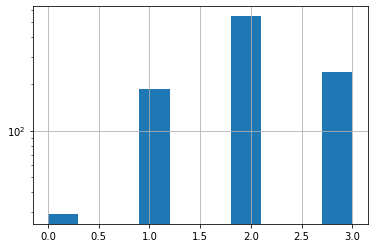

In [16]:
#クラスタリングでもいいかも
sub = pd.read_csv(f'{path}sample_submission.csv')
sub['accuracy_group'] = np.round(prediction)
sub.to_csv('submission.csv', index = False)
display(sub['accuracy_group'].value_counts())
sub['accuracy_group'].hist(log=True)
print(sub.dtypes)
print('done!')
